In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
random_state = 0

# IMPORT DATASET

In [4]:
dataset_path = parentdir + "/datasets/HARDataset/"

In [5]:
dataset_name = "HARDataset"

In [6]:
X = pd.read_csv(dataset_path + "/train/" + "X_train.txt", header=None, delim_whitespace=True)

X = pd.DataFrame(X.values)

y = pd.read_csv(dataset_path + "/train/" + "y_train.txt", header = None, delim_whitespace=True).values
y_all = np.ravel(y).astype("int")
le = LabelEncoder()
le.fit(y_all)
y_all = le.transform(y_all)
#X["class"] = y
X_all = X.values.reshape((X.shape[0], X.shape[1], 1))

In [7]:
print("X SHAPE: ", X_all.shape)
print("y SHAPE: ", y_all.shape)
unique, counts = np.unique(y_all, return_counts=True)
print("\nCLASSES BALANCE")
for i, label in enumerate(unique):
    print(label, ": ", round(counts[i]/sum(counts), 2))

X SHAPE:  (7352, 561, 1)
y SHAPE:  (7352,)

CLASSES BALANCE
0 :  0.17
1 :  0.15
2 :  0.13
3 :  0.17
4 :  0.19
5 :  0.19


In [8]:
X_test = pd.read_csv(dataset_path + "/test/" + "X_test.txt", header=None, delim_whitespace=True)

X_test = pd.DataFrame(X_test.values)

y_test = pd.read_csv(dataset_path + "/test/" + "y_test.txt", header = None, delim_whitespace=True).values
y_test = np.ravel(y_test).astype("int")
y_test = le.transform(y_test)
#X["class"] = y
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
print("X SHAPE: ", X_test.shape)
print("y SHAPE: ", y_test.shape)

X SHAPE:  (2947, 561, 1)
y SHAPE:  (2947,)


## DATASET SPLIT

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# BLACKBOX/EXPLANATION SETS SPLIT
X_train, X_exp, y_train, y_exp = train_test_split(X_all, y_all, 
                                                  test_size=0.3, stratify = y_all, random_state=random_state)

# BLACKBOX TRAIN/VALIDATION SETS SPLIT
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# EXPLANATION TRAIN/TEST SETS SPLIT
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, 
                                                                    test_size=0.2, 
                                                                    stratify = y_exp, 
                                                                    random_state=random_state)

# EXPLANATION TRAIN/VALIDATION SETS SPLIT
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp_train, y_exp_train, 
                                                                  test_size=0.2, 
                                                                  stratify = y_exp_train, 
                                                                  random_state=random_state)

print("SHAPES:")
print("BLACKBOX TRAINING SET: ", X_train.shape)
print("BLACKBOX VALIDATION SET: ", X_val.shape)
print("BLACKBOX TEST SET: ", X_test.shape)
print("EXPLANATION TRAINING SET: ", X_exp_train.shape)
print("EXPLANATION VALIDATION SET: ", X_exp_val.shape)
print("EXPLANATION TEST SET: ", X_exp_test.shape)

SHAPES:
BLACKBOX TRAINING SET:  (4116, 561, 1)
BLACKBOX VALIDATION SET:  (1030, 561, 1)
BLACKBOX TEST SET:  (2947, 561, 1)
EXPLANATION TRAINING SET:  (1411, 561, 1)
EXPLANATION VALIDATION SET:  (353, 561, 1)
EXPLANATION TEST SET:  (442, 561, 1)


In [12]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_all)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  561
N. LABELS:  6


# BLACKBOX MODELS

In [13]:
import keras
from sklearn.metrics import accuracy_score
import time
from blackboxes import *
import blackboxes
from myutils import reconstruction_blackbox_consistency

Using TensorFlow backend.


## resnet

In [14]:
blackbox = build_resnet(n_timesteps, n_outputs)
blackbox.load_weights(parentdir + "/blackbox_checkpoints/HARDataset_blackbox_resnet_20191028_172136_best_weights_+0.99_.hdf5")
resnet = blackbox

## simple CNN

In [15]:
blackbox = build_simple_CNN(n_timesteps, n_outputs)
blackbox.load_weights(parentdir + "/blackbox_checkpoints/HARDataset_blackbox_simpleCNN_20191029_153407_best_weights_+0.94_.hdf5")
simplecnn = blackbox

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [17]:
knn = load(parentdir + "/blackbox_checkpoints/HARDataset_blackbox_knn_20191031_111540.joblib")
#knn.score(X_test.reshape(X_test.shape[:2]), y_test)
#mean_squared_error(y_test, knn.predict(X_test.reshape(X_test.shape[:2])))

# AUTOENCODER

In [18]:
import autoencoders
from autoencoders import *
import importlib
importlib.reload(autoencoders)

<module 'autoencoders' from '/Users/francesco/github/TS_AgnosticLocalExplainer/autoencoders.py'>

## Standard

In [19]:
params = {"input_shape": (n_timesteps,1),
          "n_blocks": 8, 
          "latent_dim": 50,
          "encoder_latent_layer_type": "dense",
          "encoder_args": {"filters":[2,4,8,16,32,64,128,256], 
                            "kernel_size":[21,18,15,13,11,8,5,3], 
                            "padding":"same", 
                            "activation":"selu", 
                            "pooling":[1,1,1,1,1,1,1,1]}
         }

aut = Autoencoder(verbose = False, **params)
encoder, decoder, autoencoder = aut.build()
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/HARDataset_autoencoder_20191031_212226_best_weights_+0.008519_.hdf5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# NEIGHBORHOOD GENERATION

In [20]:
import agnosticlocalexplainer
from agnosticlocalexplainer import *
import importlib
importlib.reload(agnosticlocalexplainer)

/Users/francesco/anaconda3/envs/tesi/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


<module 'agnosticlocalexplainer' from '/Users/francesco/github/TS_AgnosticLocalExplainer/agnosticlocalexplainer.py'>

In [21]:
index_to_explain = 4

## RESNET

In [22]:
blackbox = resnet

In [23]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [24]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 3, 
                                  labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", 
                                            "SITTING", "STANDING", "LAYING"]
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  LAYING (5)


In [25]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 1000, 
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)

calculating feature values
gen	nevals	avg     	min     	max     
0  	250   	0.496654	0.496654	0.496654
1  	213   	0.544923	0.48641 	0.992241
2  	221   	0.603296	0.473443	0.993307
3  	215   	0.668407	0.482402	0.993307
4  	210   	0.685844	0.478159	0.993307
5  	213   	0.681912	0.474031	0.993105
6  	215   	0.701538	0.465345	0.993105
7  	212   	0.715519	0.47592 	0.993116
8  	195   	0.745388	0.478645	0.993105
9  	209   	0.709708	0.466716	0.993105
10 	210   	0.71409 	0.473064	0.993105
gen	nevals	avg	min	max
0  	250   	0.5	0.5	0.5
1  	227   	0.732066	0.493712	0.992285
2  	206   	0.928316	0.490818	0.992427
3  	207   	0.964768	0.489197	0.992427
4  	220   	0.965068	0.488299	0.992589
5  	220   	0.975533	0.489543	0.992589
6  	206   	0.969846	0.490274	0.992387
7  	203   	0.981534	0.489628	0.992638
8  	219   	0.969931	0.492321	0.992665
9  	215   	0.969568	0.493875	0.992641
10 	205   	0.97042 	0.491309	0.992531
synthetic neighborhood class counts {0: 110, 1: 82, 2: 64, 3: 352, 4: 286, 5: 155}


In [26]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [27]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1


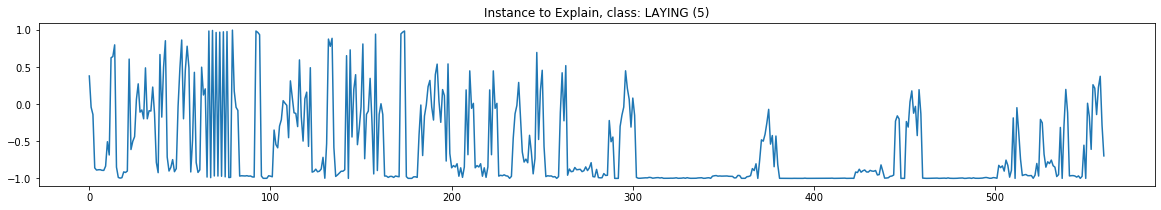

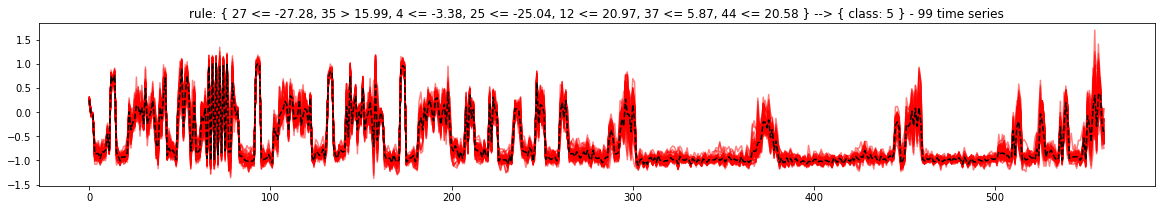

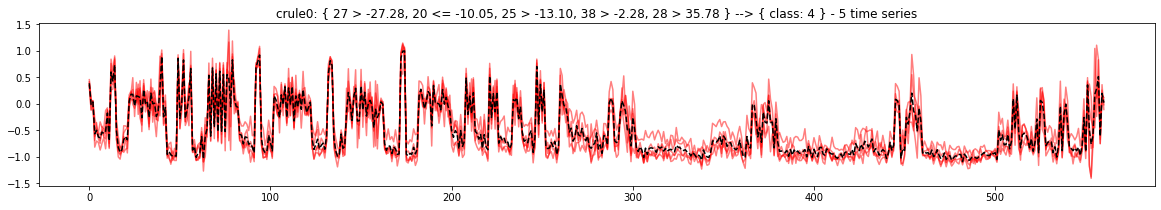

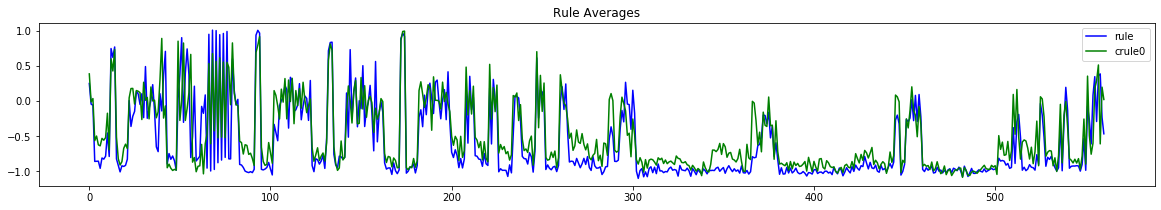

rule


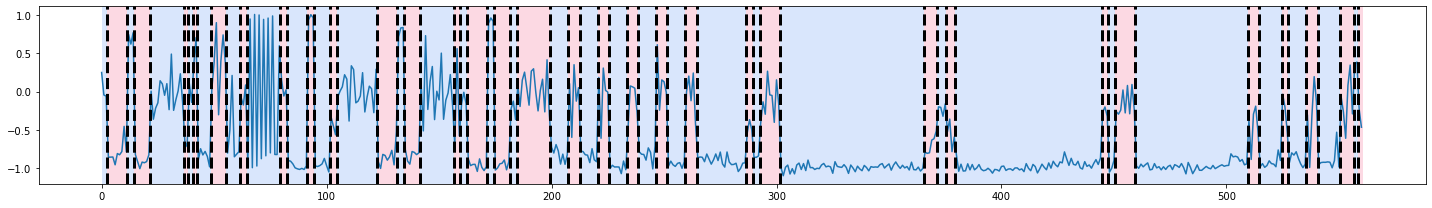

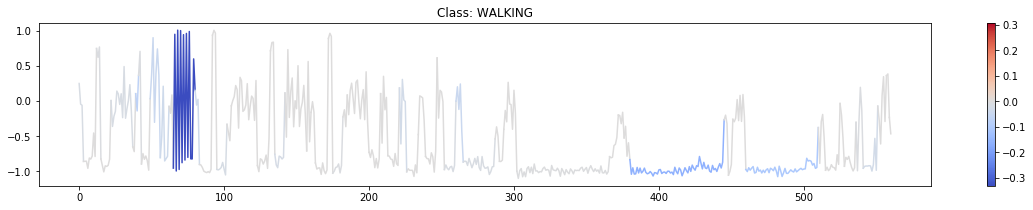

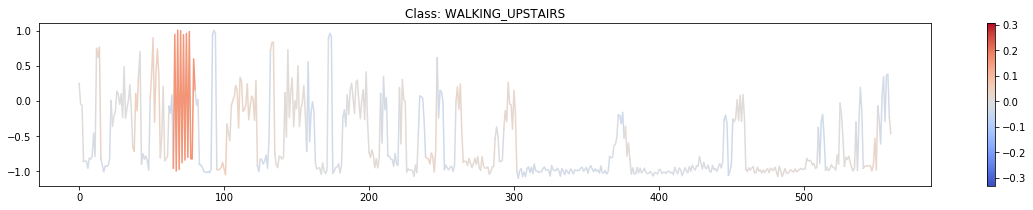

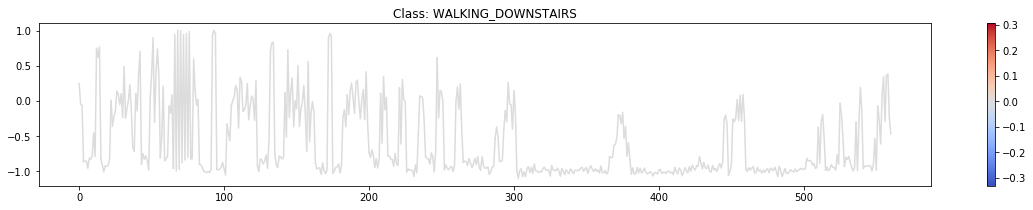

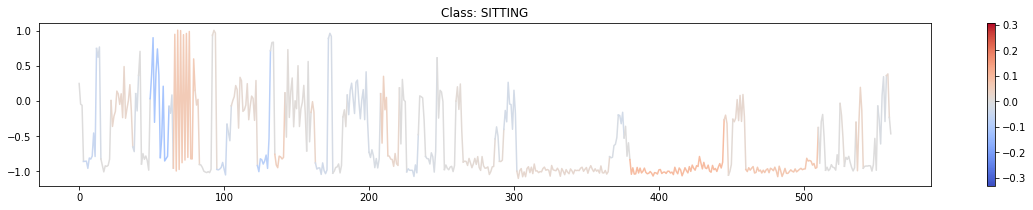

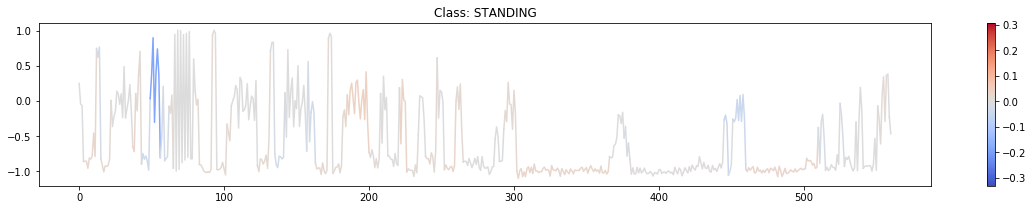

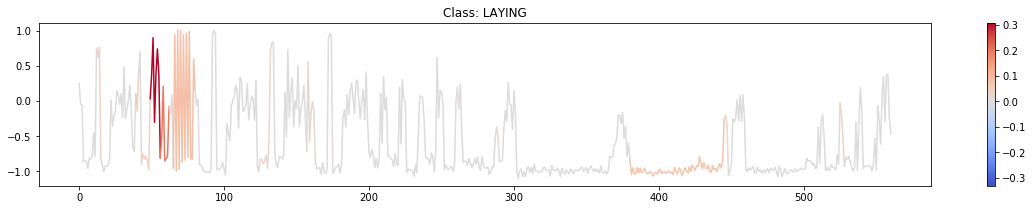

crule0


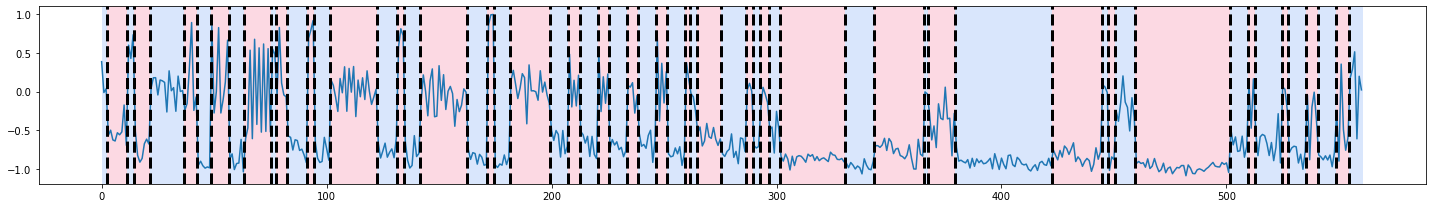

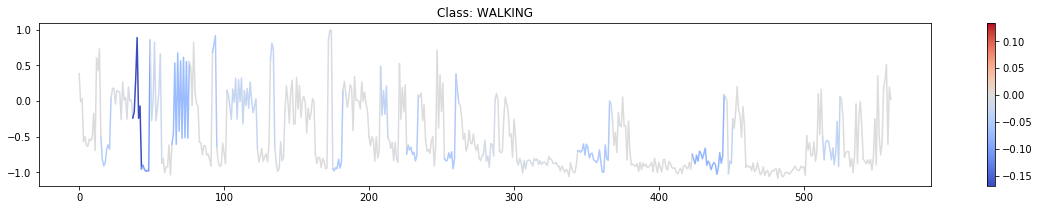

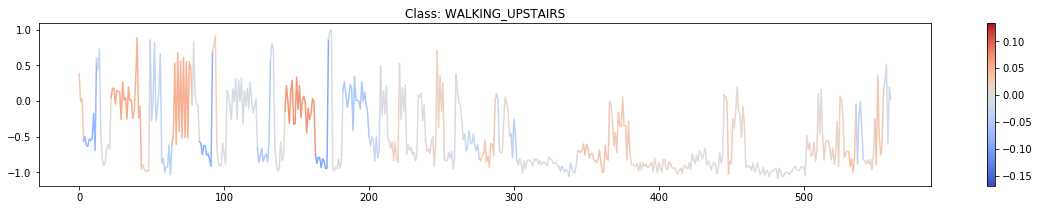

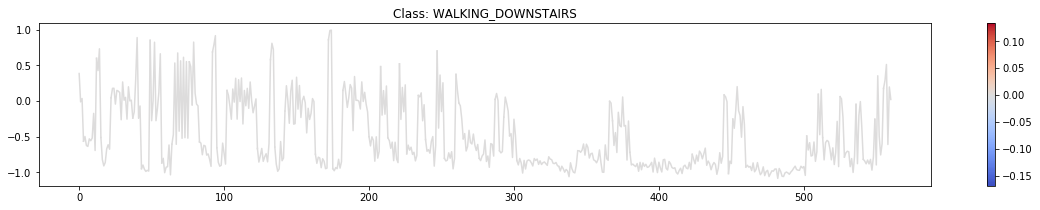

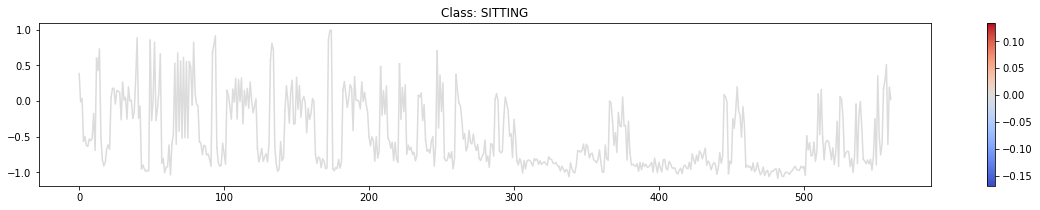

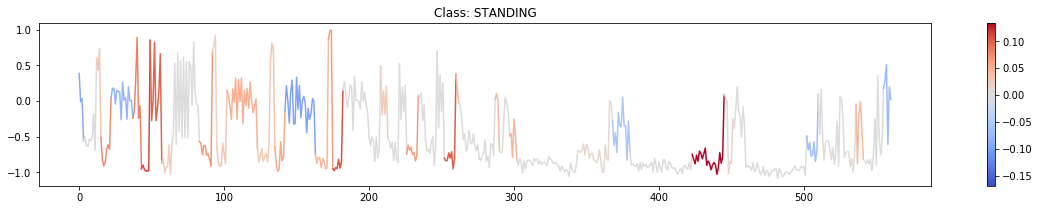

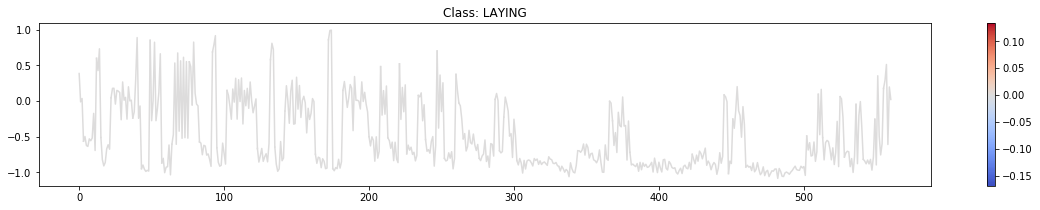



Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    7.0s finished


rule
Rules used to predict sample 0: 
sample predicted class:  LAYING
decision id node 0 : (shapelet n. 11 (distance = 0.17439462) > 0.12948864698410034)
decision id node 14 : (shapelet n. 9 (distance = 0.030019352) <= 0.03495822660624981)
decision id node 15 : (shapelet n. 6 (distance = 0.07569041) > 0.07301242277026176)
decision id node 19 : (shapelet n. 4 (distance = 0.05508096) <= 0.055191520601511)


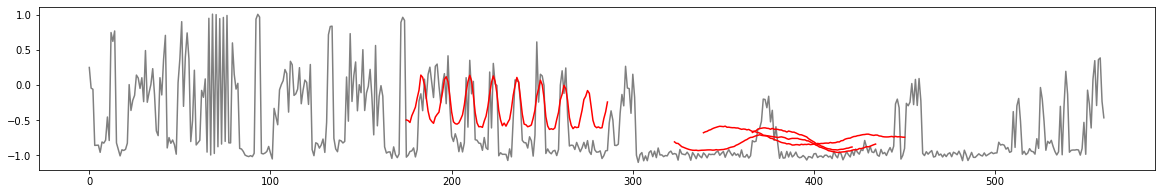

decision id node 0 : (shapelet n. 11 (distance = 0.17439462) > 0.12948864698410034)


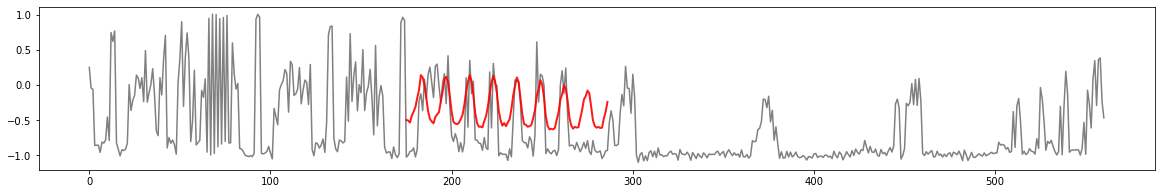

decision id node 14 : (shapelet n. 9 (distance = 0.030019352) <= 0.03495822660624981)


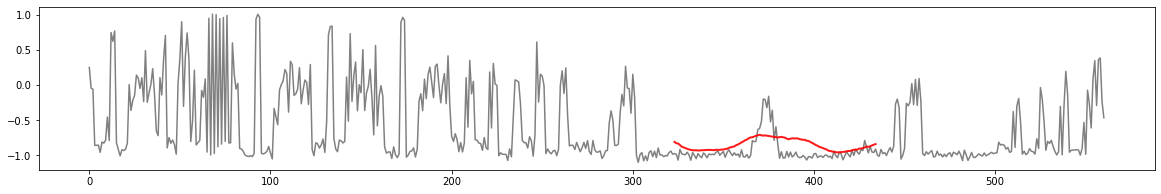

decision id node 15 : (shapelet n. 6 (distance = 0.07569041) > 0.07301242277026176)


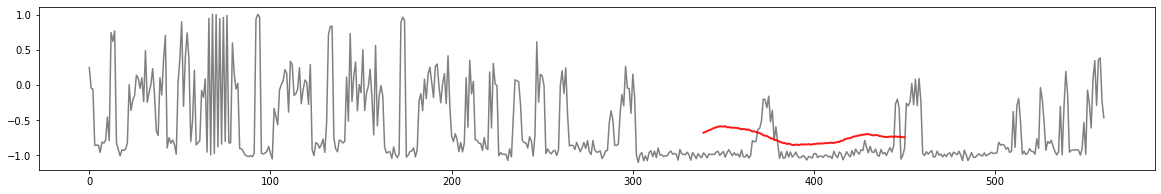

decision id node 19 : (shapelet n. 4 (distance = 0.05508096) <= 0.055191520601511)


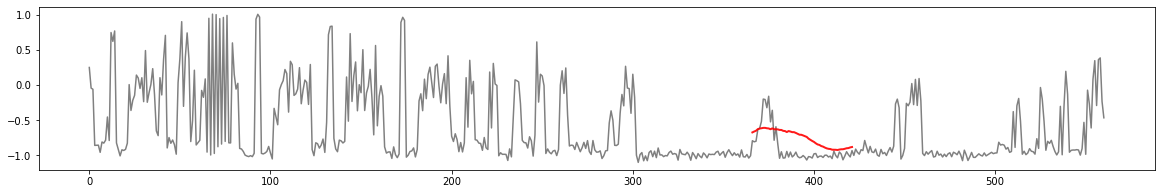

crule0
Rules used to predict sample 0: 
sample predicted class:  STANDING
decision id node 0 : (shapelet n. 11 (distance = 0.10807477) <= 0.12948864698410034)
decision id node 1 : (shapelet n. 9 (distance = 0.037237033) <= 0.05398130789399147)
decision id node 2 : (shapelet n. 0 (distance = 0.0876077) > 0.08388475328683853)
decision id node 6 : (shapelet n. 5 (distance = 0.085923776) <= 0.10622343420982361)


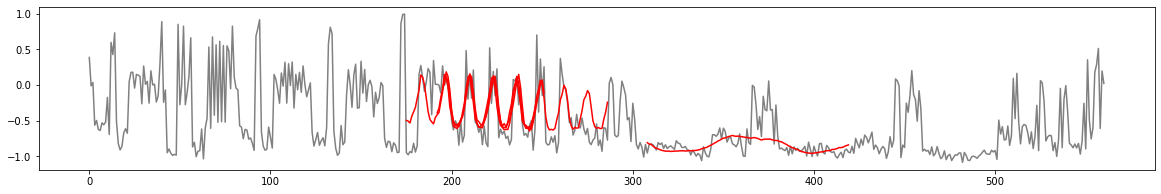

decision id node 0 : (shapelet n. 11 (distance = 0.10807477) <= 0.12948864698410034)


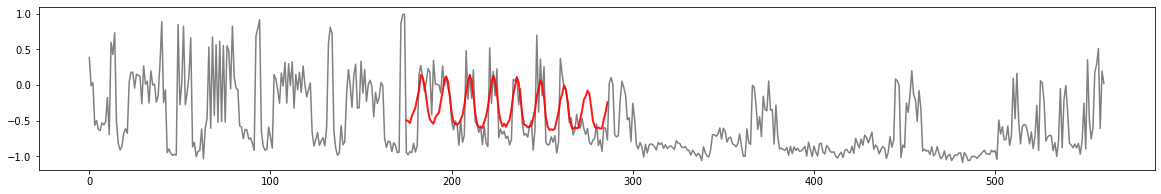

decision id node 1 : (shapelet n. 9 (distance = 0.037237033) <= 0.05398130789399147)


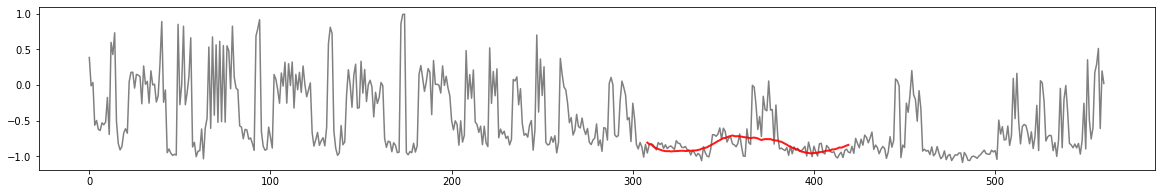

decision id node 2 : (shapelet n. 0 (distance = 0.0876077) > 0.08388475328683853)


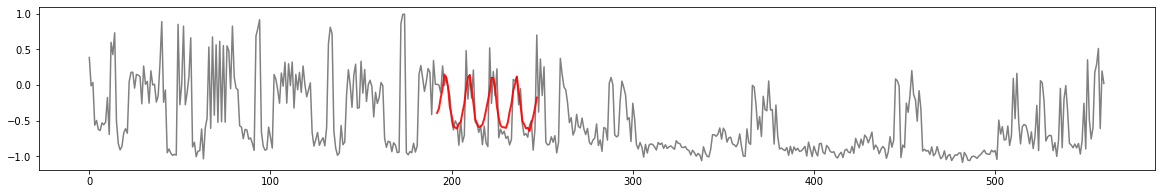

decision id node 6 : (shapelet n. 5 (distance = 0.085923776) <= 0.10622343420982361)


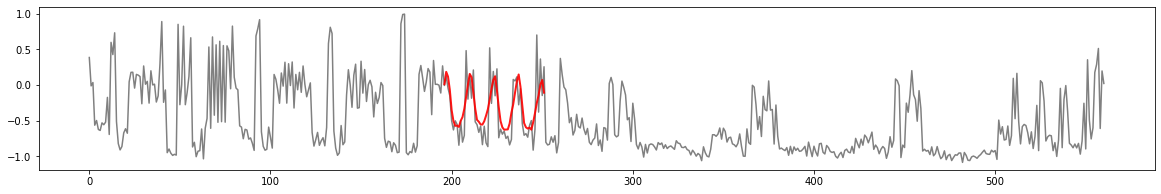

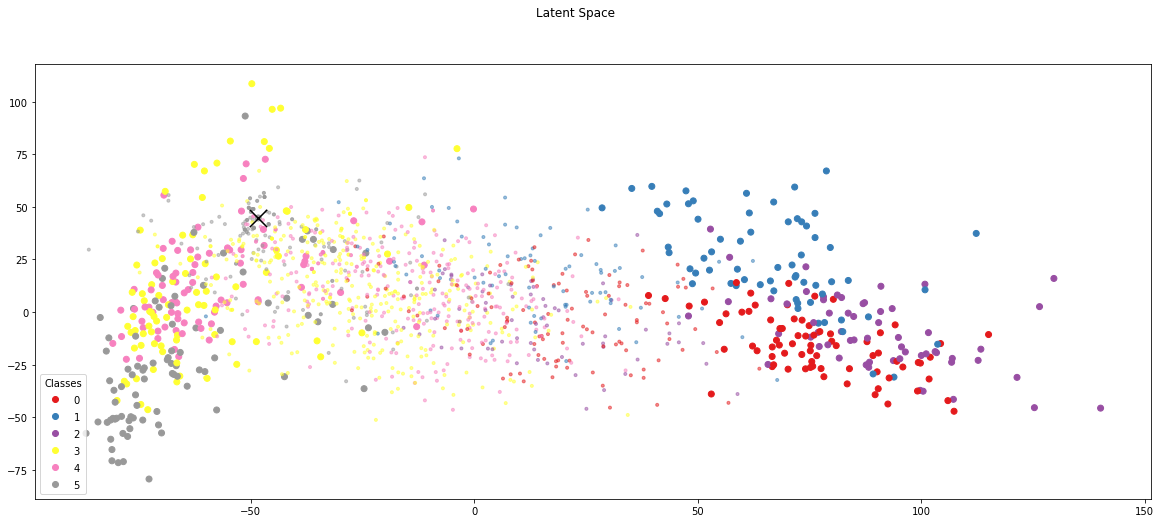

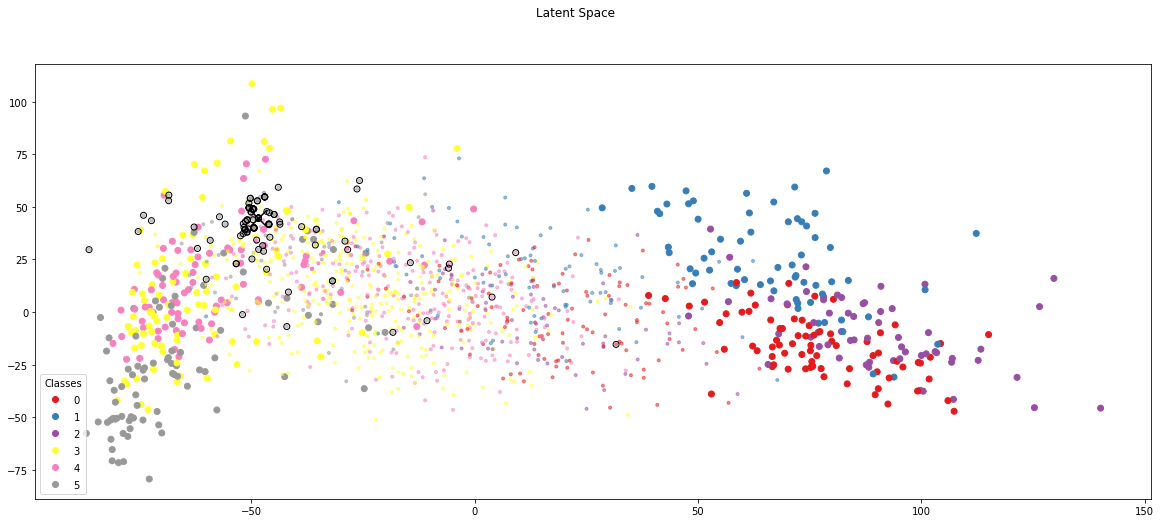

In [28]:
params = {"nsamples":1000, 
          "background":"linear", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "max_iter":100}
agnostic.plot_explanation(rules = True,
                          heatmap = False,
                          shap_explanation = True,
                          shapelet_explanation = True,
                          figsize = (20,3), 
                          **params
                         )

## SIMPLE CNN

In [29]:
blackbox = simplecnn

In [30]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [31]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 3
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  5


In [32]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 1000, 
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)

calculating feature values
gen	nevals	avg     	min     	max     
0  	250   	0.496654	0.496654	0.496654
1  	213   	0.53703 	0.48641 	0.992241
2  	221   	0.593458	0.473443	0.993307
3  	215   	0.658437	0.482402	0.993307
4  	210   	0.675852	0.478159	0.993307
5  	213   	0.673963	0.474031	0.99311 
6  	215   	0.685511	0.465345	0.99311 
7  	212   	0.699764	0.478876	0.993253
8  	195   	0.73148 	0.474925	0.993253
9  	209   	0.709669	0.474294	0.993253
10 	210   	0.7002  	0.478762	0.993253
gen	nevals	avg	min	max
0  	250   	0.5	0.5	0.5
1  	227   	0.730092	0.492821	0.992285
2  	206   	0.928302	0.490818	0.992427
3  	207   	0.970664	0.492288	0.992427
4  	220   	0.97097 	0.488299	0.992589
5  	220   	0.979462	0.489543	0.992589
6  	206   	0.967854	0.488152	0.992387
7  	203   	0.977616	0.489628	0.992638
8  	219   	0.977817	0.492321	0.992665
9  	215   	0.977525	0.493875	0.992681
10 	205   	0.974407	0.493131	0.992681
synthetic neighborhood class counts {0: 109, 1: 57, 2: 169, 3: 298, 4: 273, 5: 143}


In [33]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [34]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  0


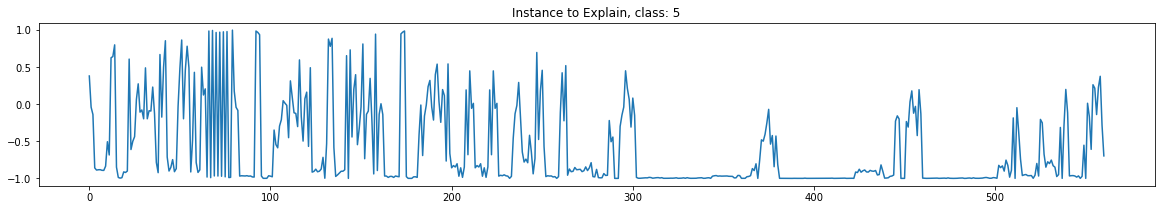

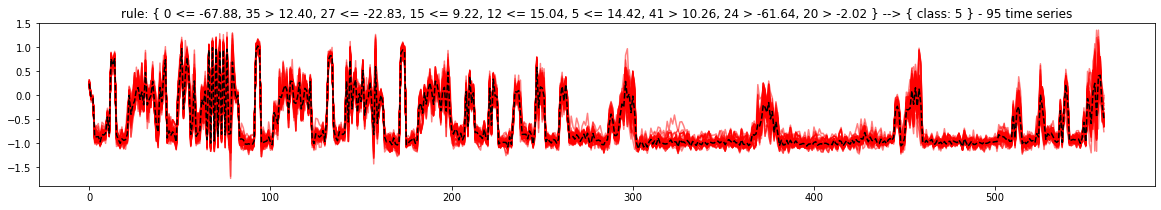

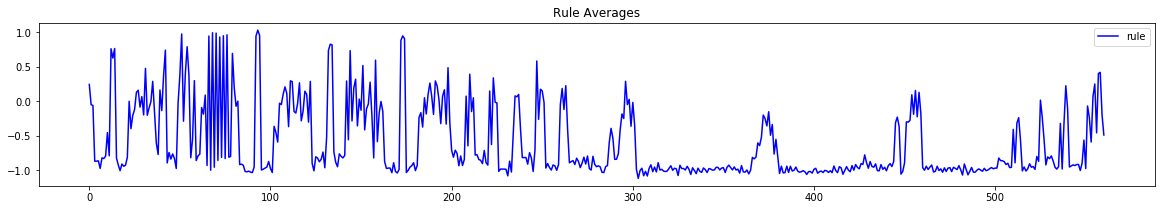

rule


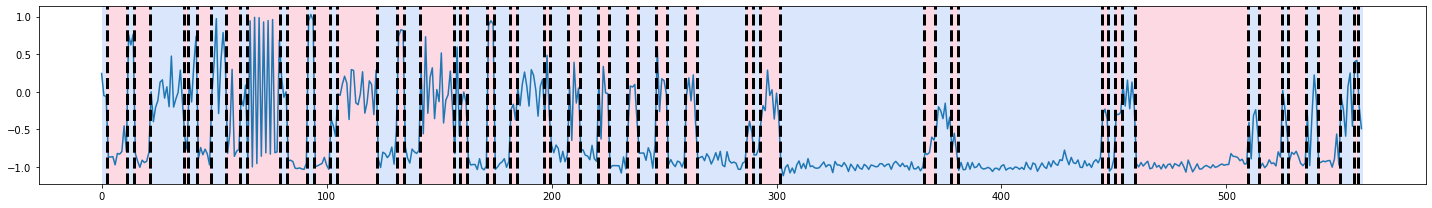

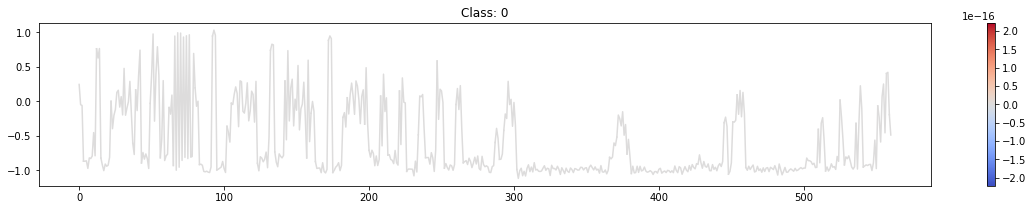

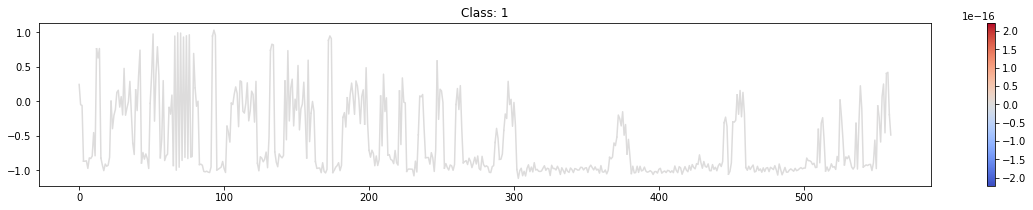

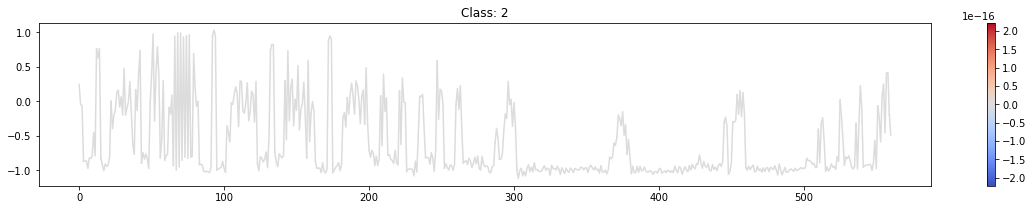

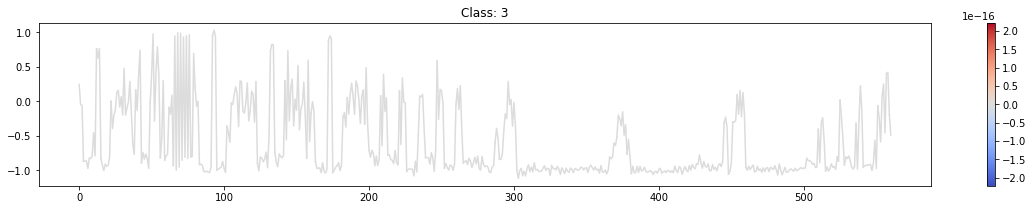

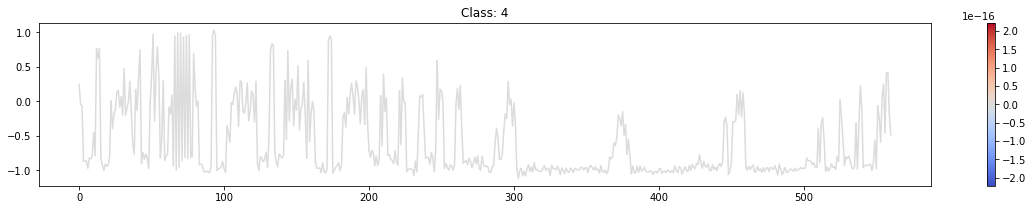

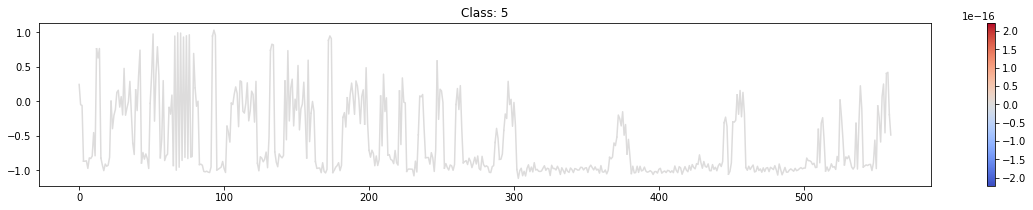

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished


rule
Rules used to predict sample 0: 
sample predicted class:  5
decision id node 0 : (shapelet n. 8 (distance = 0.1858994) > 0.14796264469623566)
decision id node 16 : (shapelet n. 1 (distance = 0.15681472) <= 0.1697612702846527)
decision id node 17 : (shapelet n. 8 (distance = 0.1858994) > 0.17197880148887634)
decision id node 21 : (shapelet n. 9 (distance = 0.026439123) <= 0.02923679444938898)


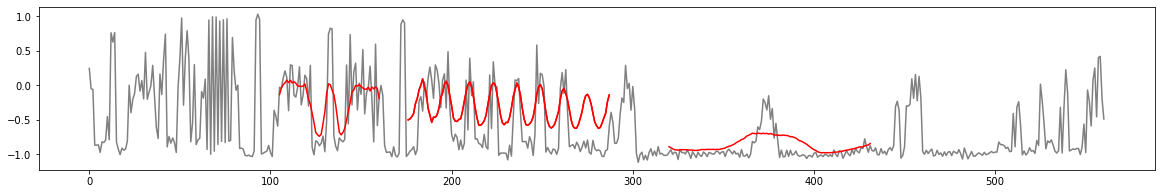

decision id node 0 : (shapelet n. 8 (distance = 0.1858994) > 0.14796264469623566)


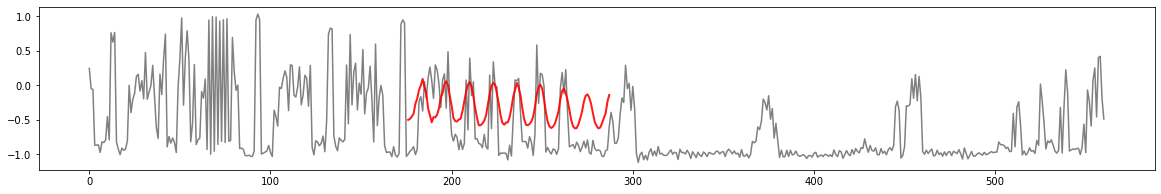

decision id node 16 : (shapelet n. 1 (distance = 0.15681472) <= 0.1697612702846527)


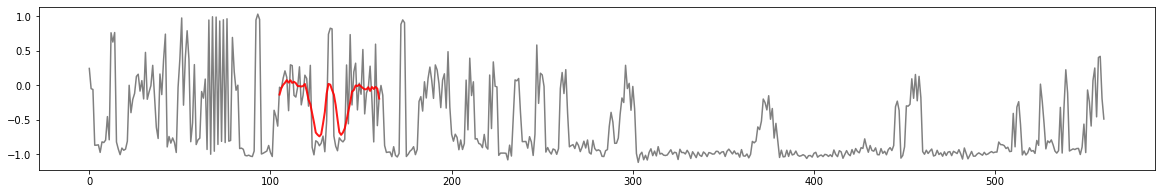

decision id node 17 : (shapelet n. 8 (distance = 0.1858994) > 0.17197880148887634)


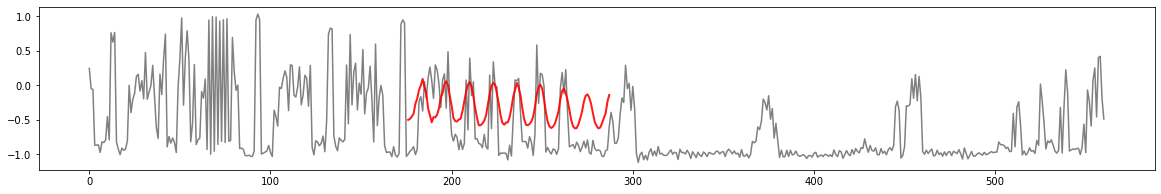

decision id node 21 : (shapelet n. 9 (distance = 0.026439123) <= 0.02923679444938898)


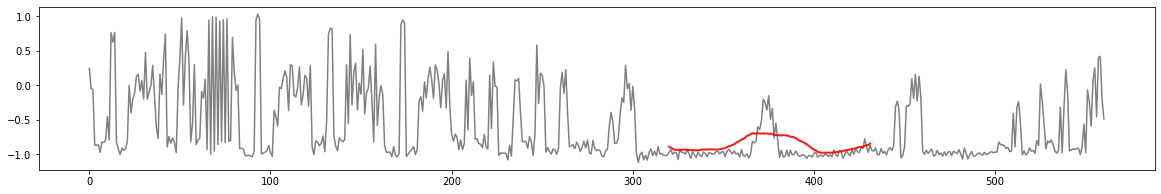

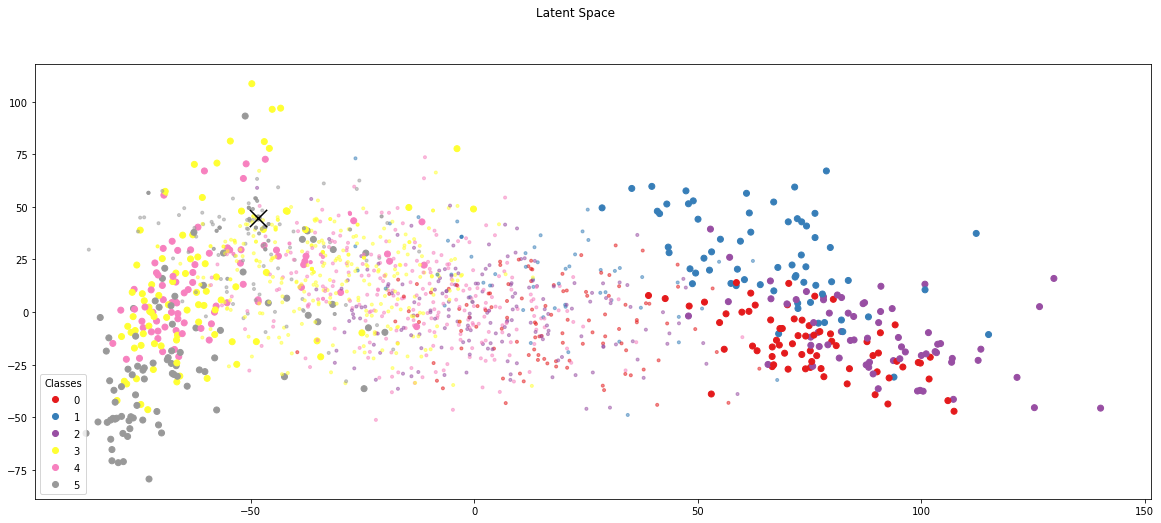

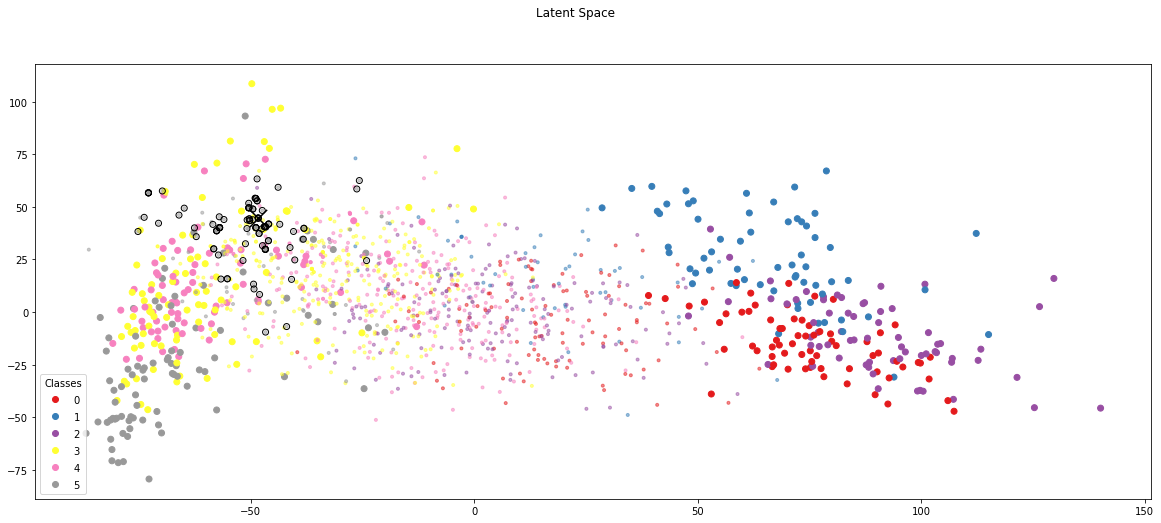

In [35]:
params = {"nsamples":1000, 
          "background":"linear", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "max_iter":100}
agnostic.plot_explanation(rules = True,
                          heatmap = False,
                          shap_explanation = True,
                          shapelet_explanation = True,
                          figsize = (20,3), 
                          **params
                         )

## KNN

In [36]:
blackbox = knn

In [37]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [38]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 2
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  5


In [39]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 1000, 
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)

calculating feature values
gen	nevals	avg     	min     	max     
0  	250   	0.496654	0.496654	0.496654
1  	213   	0.643584	0.48641 	0.992241
2  	221   	0.738543	0.473443	0.993307
3  	215   	0.783946	0.481301	0.993307
4  	210   	0.792126	0.472517	0.993307
5  	213   	0.764605	0.47396 	0.993105
6  	215   	0.780596	0.477644	0.993113
7  	212   	0.792799	0.479561	0.993105
8  	195   	0.824555	0.476613	0.993105
9  	209   	0.798838	0.476567	0.993106
10 	210   	0.793413	0.48319 	0.993105
gen	nevals	avg	min	max
0  	250   	0.5	0.5	0.5
1  	227   	0.623538	0.490505	0.991813
2  	206   	0.780645	0.485135	0.991813
3  	207   	0.928046	0.480602	0.991813
4  	220   	0.955451	0.483065	0.991925
5  	220   	0.95024 	0.489143	0.991813
6  	206   	0.952249	0.484495	0.991813
7  	203   	0.956479	0.486088	0.991813
8  	219   	0.96064 	0.489301	0.991813
9  	215   	0.938952	0.491185	0.991813
10 	205   	0.947249	0.487012	0.99217 
synthetic neighborhood class counts {0: 164, 1: 109, 2: 4, 3: 212, 4: 337, 5: 223}


In [40]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [41]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  0


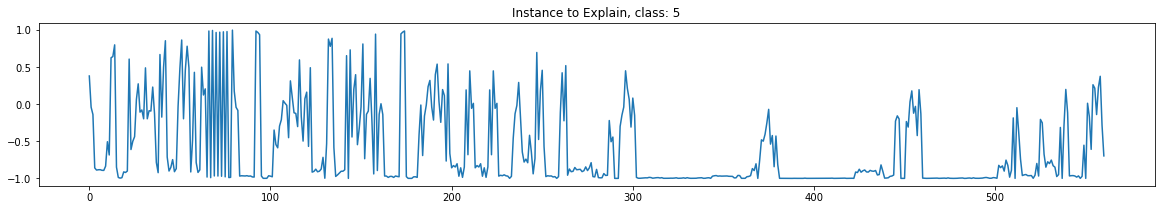

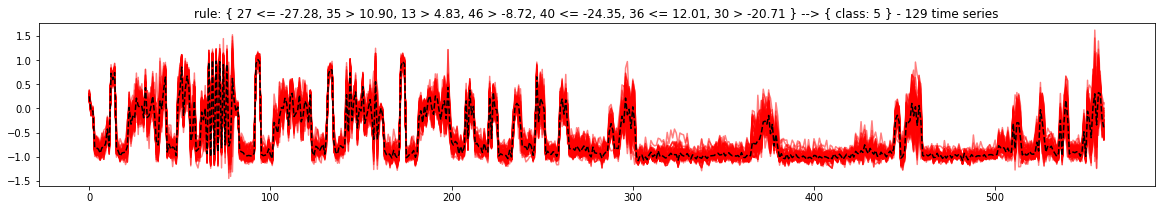

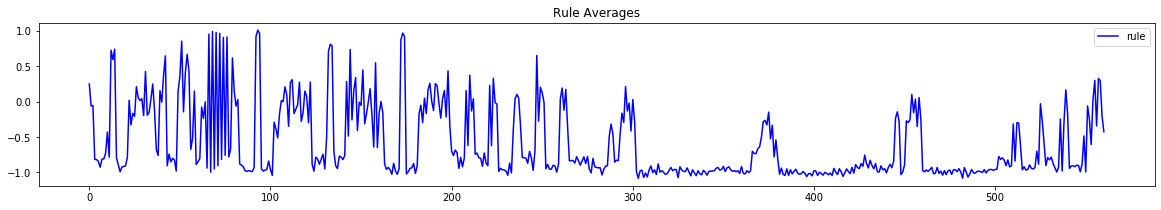

rule


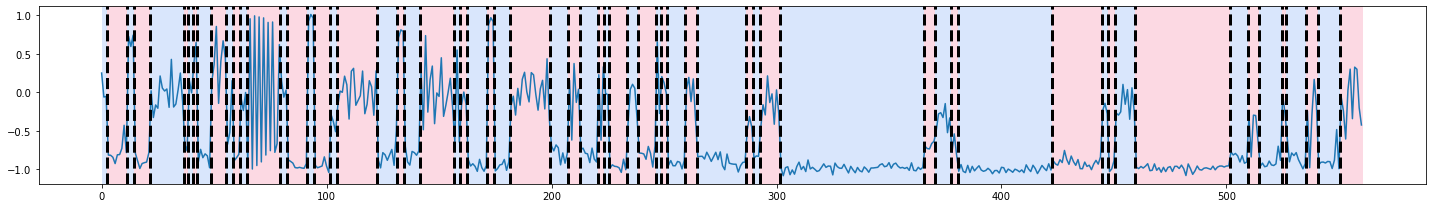

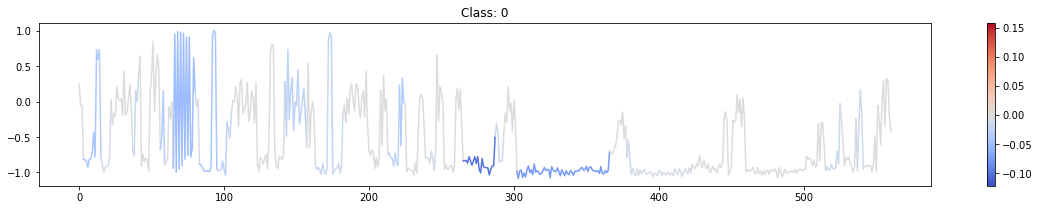

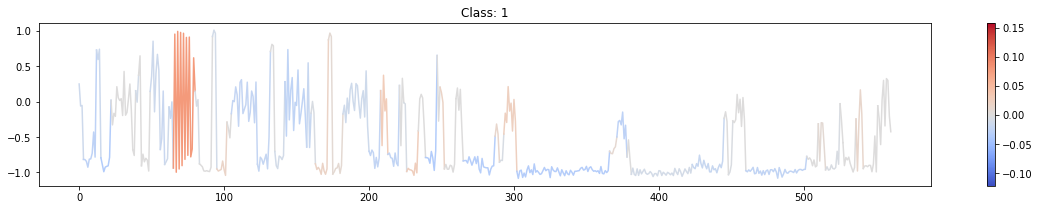

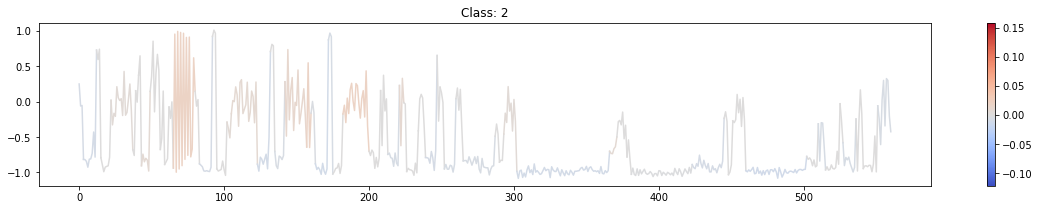

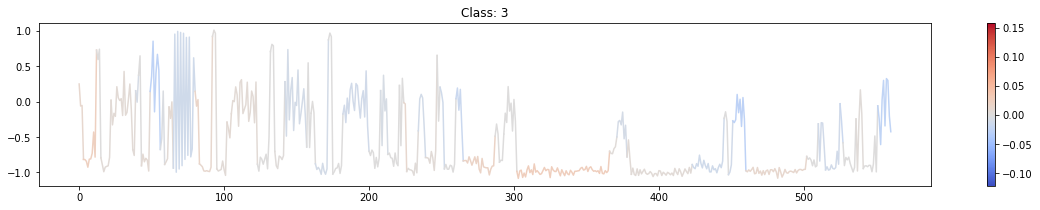

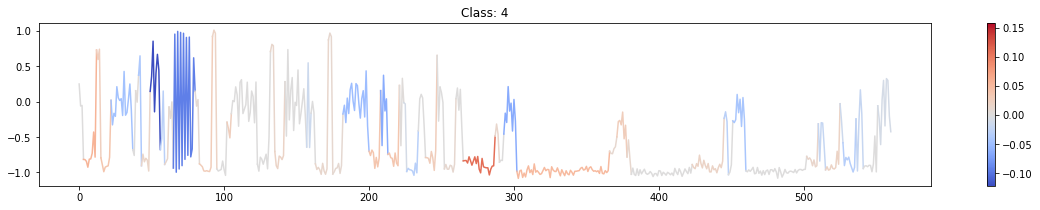

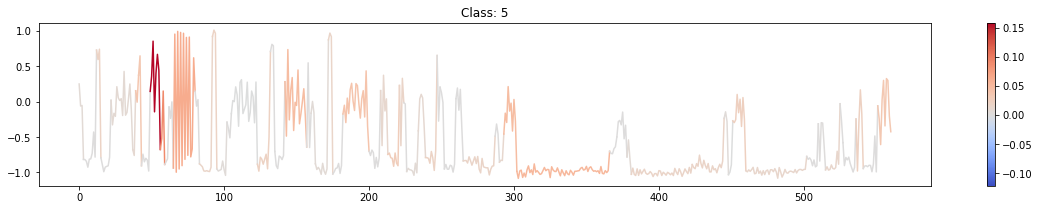

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 211 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.4s finished


rule
Rules used to predict sample 0: 
sample predicted class:  5
decision id node 0 : (shapelet n. 9 (distance = 0.16681999) > 0.14217913150787354)
decision id node 20 : (shapelet n. 8 (distance = 0.16562292) <= 0.1807132586836815)
decision id node 21 : (shapelet n. 6 (distance = 0.14913233) <= 0.1536148488521576)
decision id node 22 : (shapelet n. 7 (distance = 0.04957581) <= 0.05078159272670746)
decision id node 23 : (shapelet n. 5 (distance = 0.13330035) > 0.13055936247110367)


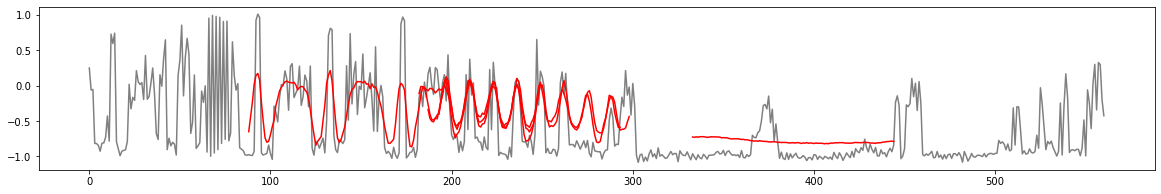

decision id node 0 : (shapelet n. 9 (distance = 0.16681999) > 0.14217913150787354)


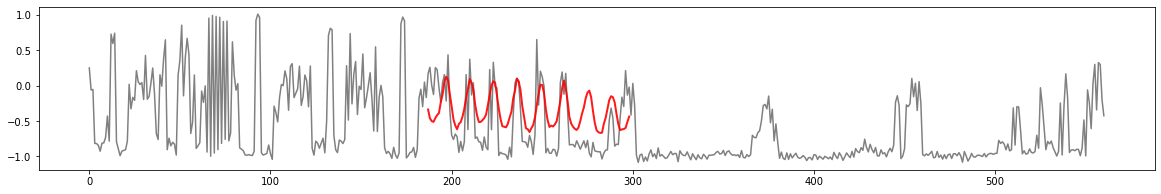

decision id node 20 : (shapelet n. 8 (distance = 0.16562292) <= 0.1807132586836815)


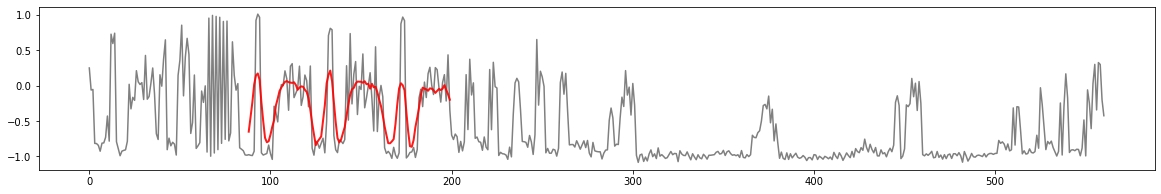

decision id node 21 : (shapelet n. 6 (distance = 0.14913233) <= 0.1536148488521576)


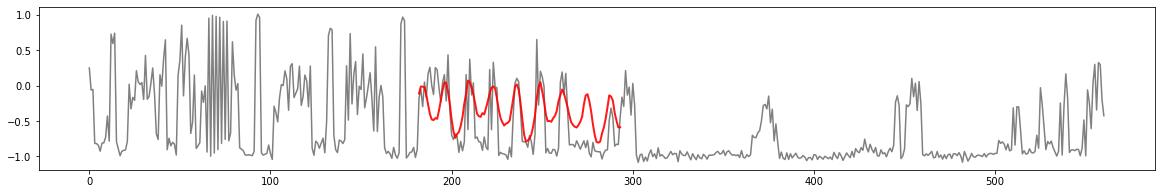

decision id node 22 : (shapelet n. 7 (distance = 0.04957581) <= 0.05078159272670746)


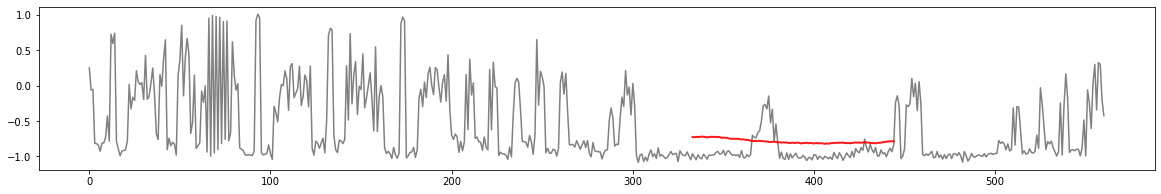

decision id node 23 : (shapelet n. 5 (distance = 0.13330035) > 0.13055936247110367)


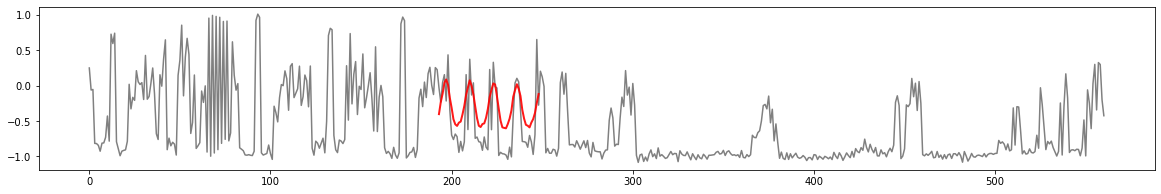

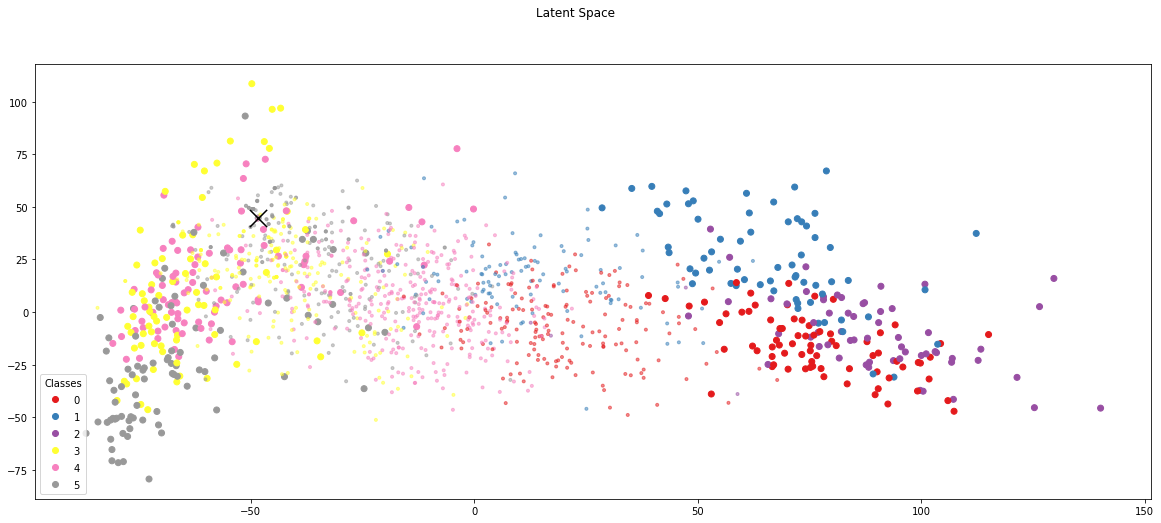

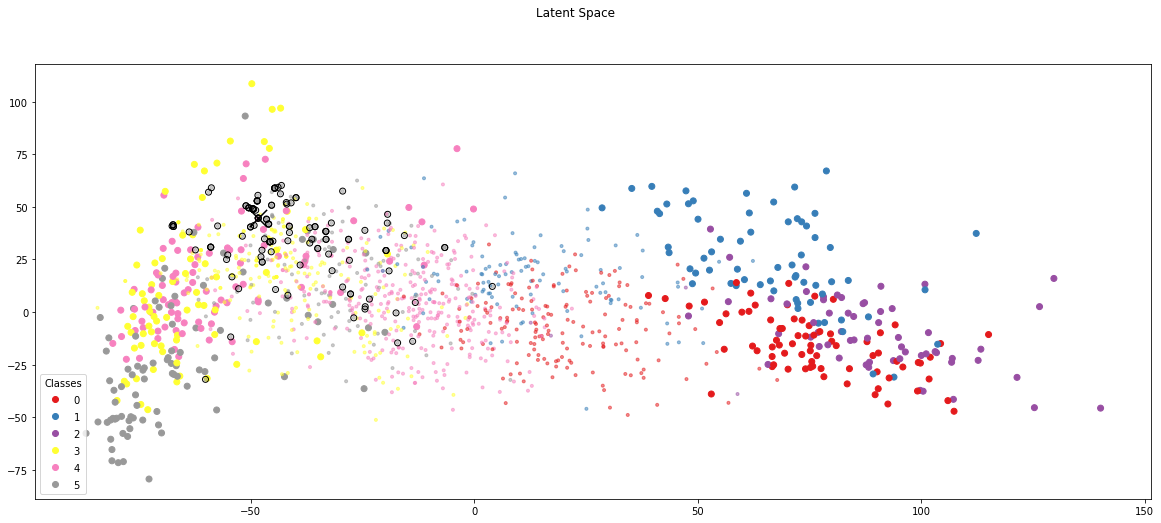

In [42]:
params = {"nsamples":1000, 
          "background":"linear", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "max_iter":100}
agnostic.plot_explanation(rules = True,
                          heatmap = False,
                          shap_explanation = True,
                          shapelet_explanation = True,
                          figsize = (20,3), 
                          **params
                         )

# PROVE

In [26]:
blackbox = resnet

In [27]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [28]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = 3, 
                                  labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", 
                                            "SITTING", "STANDING", "LAYING"]
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  LAYING (5)


In [29]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'rndgen', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 1000, 
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True,
                          ngen = 10)

calculating feature values
gen	nevals	avg     	min     	max     
0  	250   	0.496654	0.496654	0.496654
1  	213   	0.544923	0.48641 	0.992241
2  	221   	0.603296	0.473443	0.993307
3  	215   	0.668407	0.482402	0.993307
4  	210   	0.685844	0.478159	0.993307
5  	213   	0.681912	0.474031	0.993105
6  	215   	0.701538	0.465345	0.993105
7  	212   	0.715519	0.47592 	0.993116
8  	195   	0.745388	0.478645	0.993105
9  	209   	0.709708	0.466716	0.993105
10 	210   	0.71409 	0.473064	0.993105
gen	nevals	avg	min	max
0  	250   	0.5	0.5	0.5
1  	227   	0.732066	0.493712	0.992285
2  	206   	0.928316	0.490818	0.992427
3  	207   	0.964768	0.489197	0.992427
4  	220   	0.965068	0.488299	0.992589
5  	220   	0.975533	0.489543	0.992589
6  	206   	0.969846	0.490274	0.992387
7  	203   	0.981534	0.489628	0.992638
8  	219   	0.969931	0.492321	0.992665
9  	215   	0.969568	0.493875	0.992641
10 	205   	0.97042 	0.491309	0.992531
synthetic neighborhood class counts {0: 110, 1: 82, 2: 64, 3: 352, 4: 286, 5: 155}


In [30]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [31]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  1


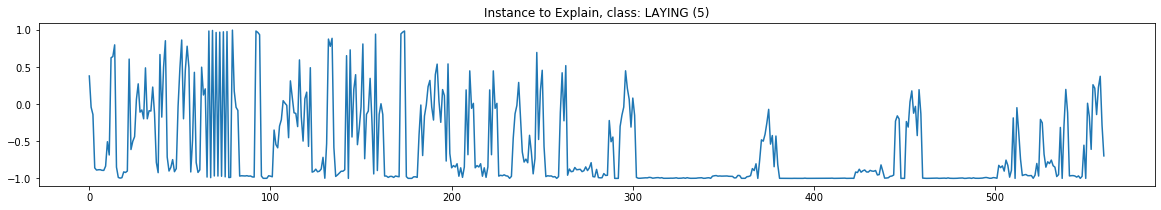

rule


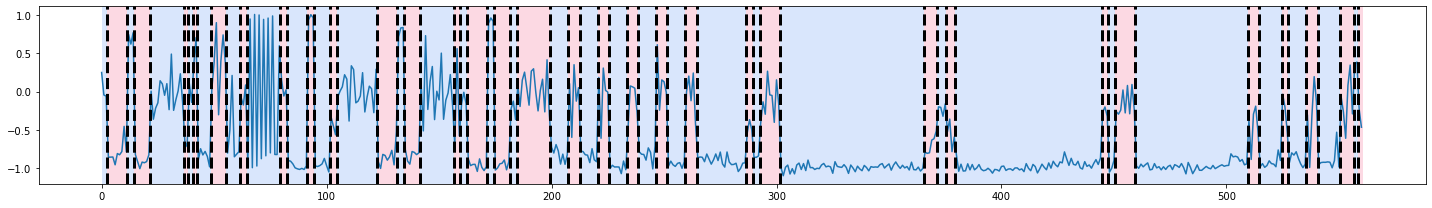

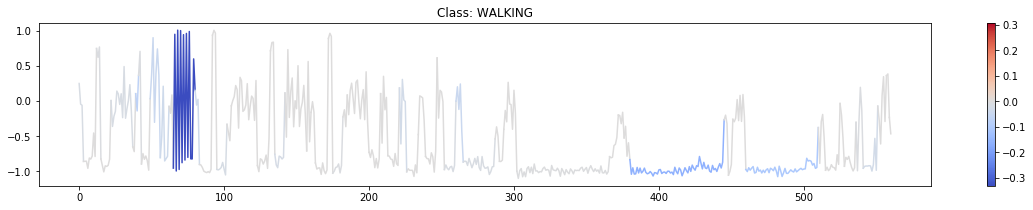

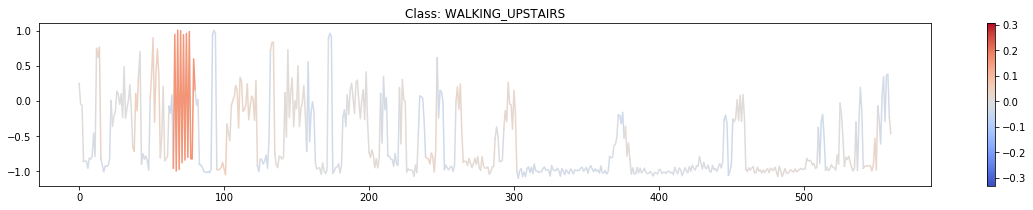

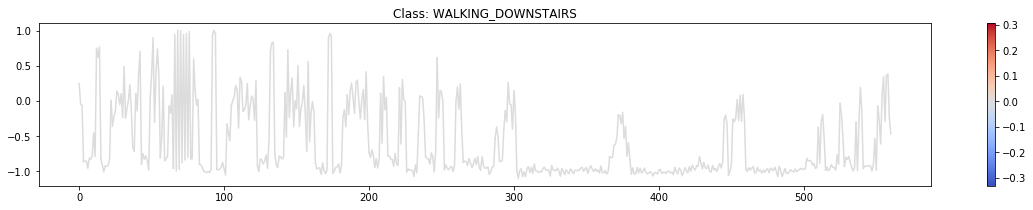

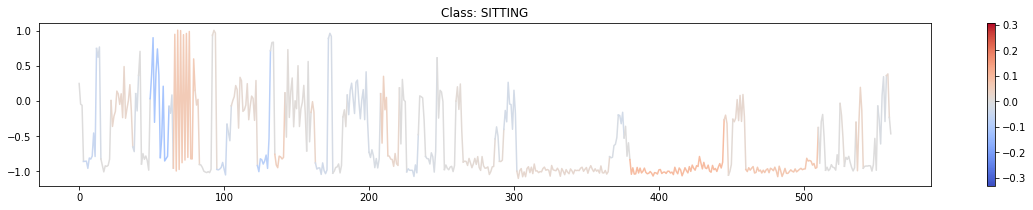

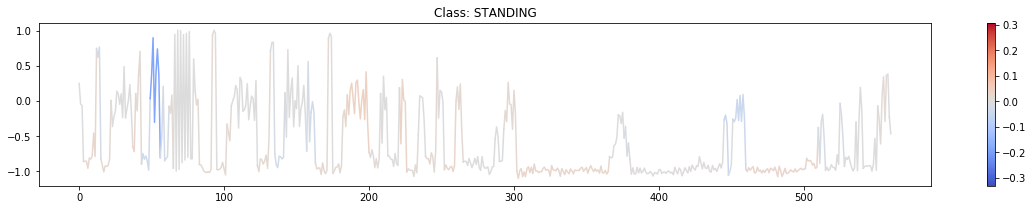

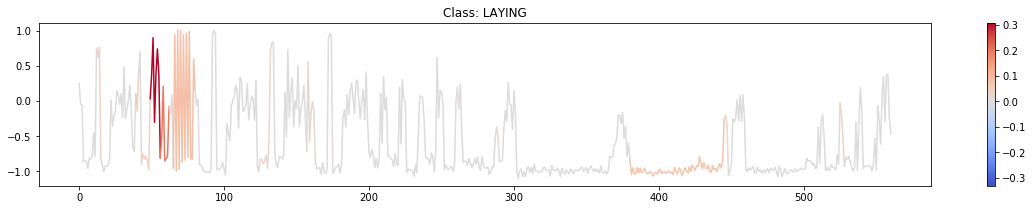

crule0


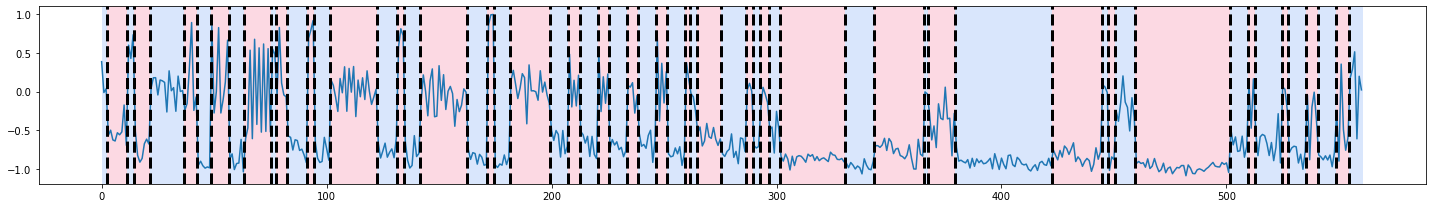

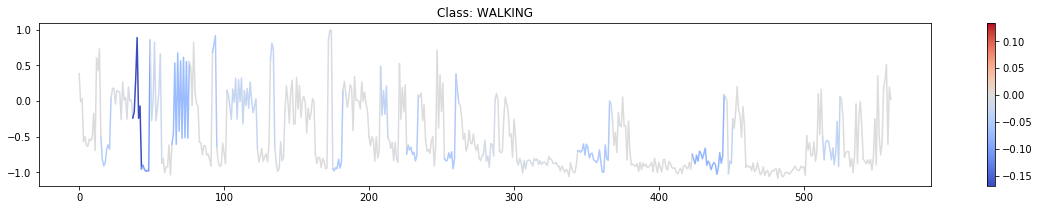

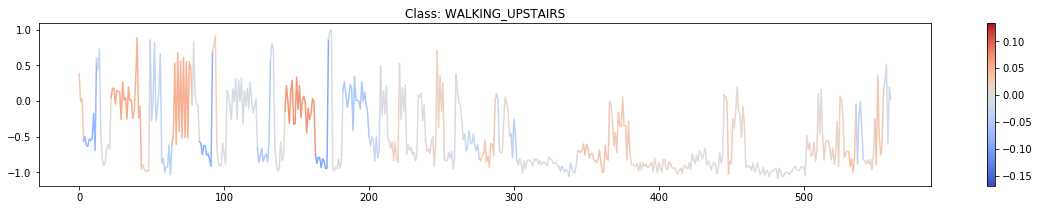

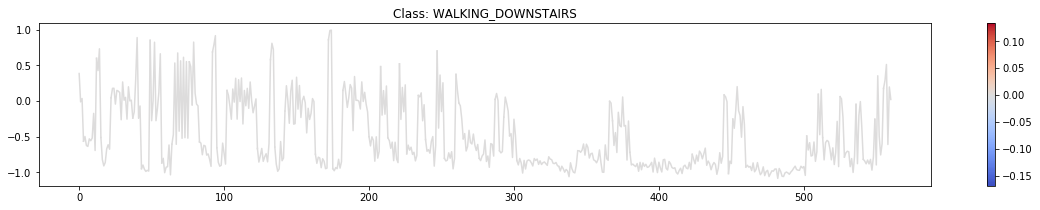

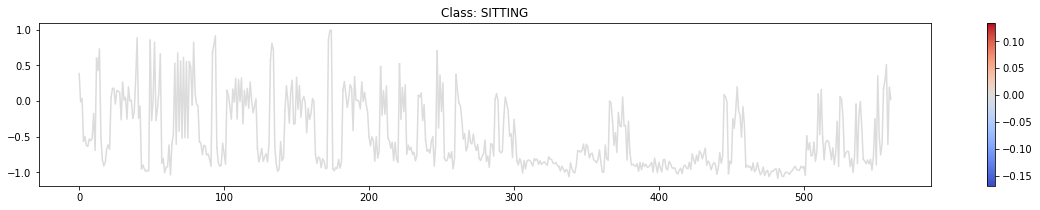

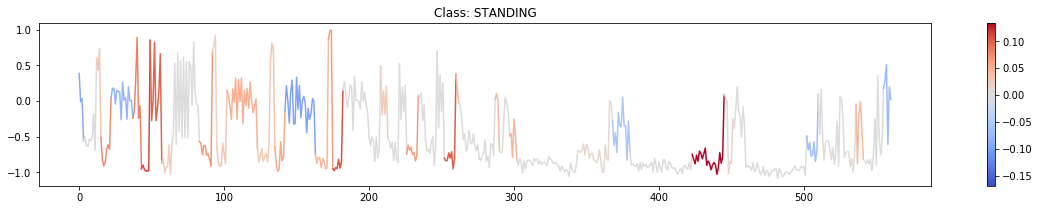

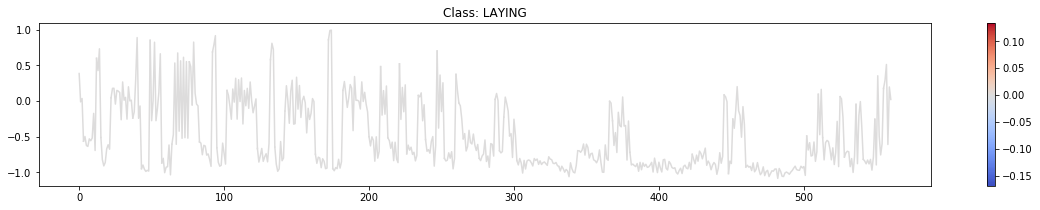

rule


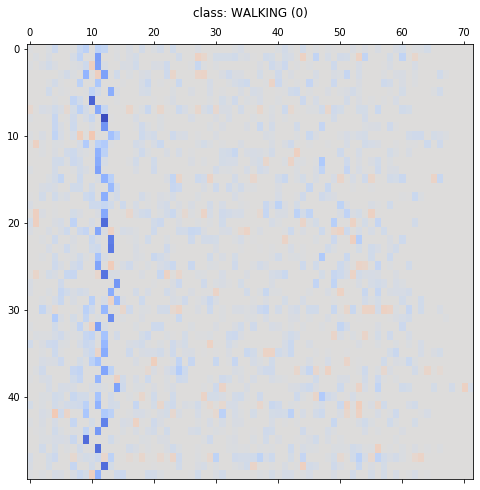

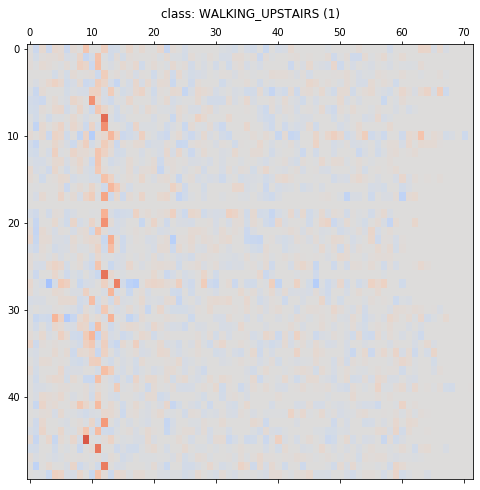

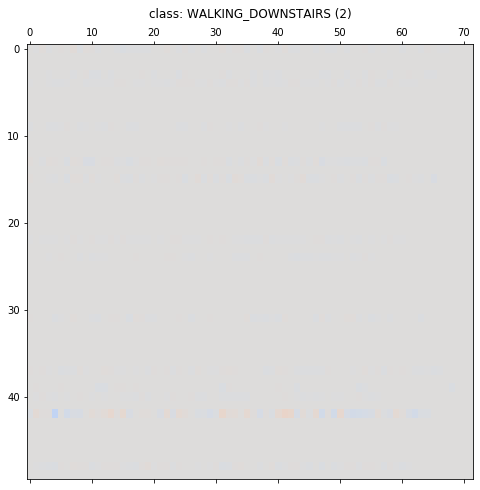

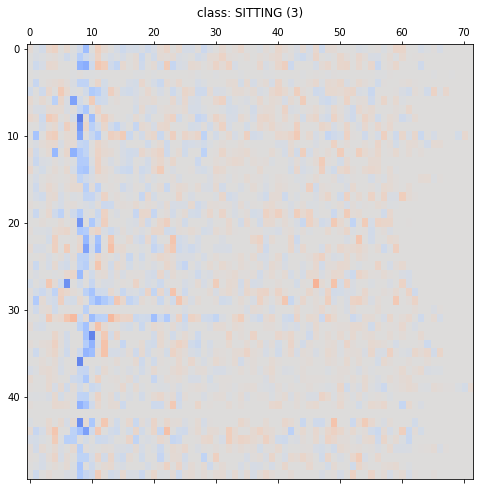

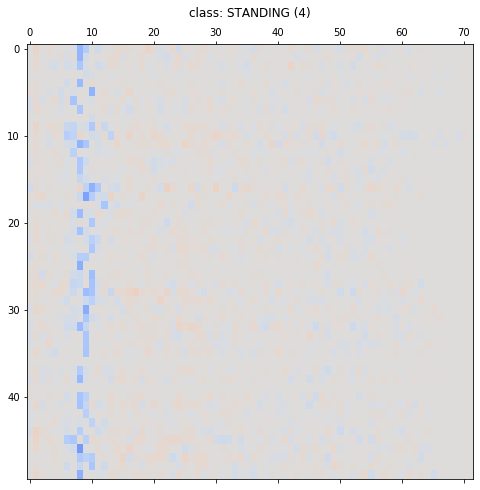

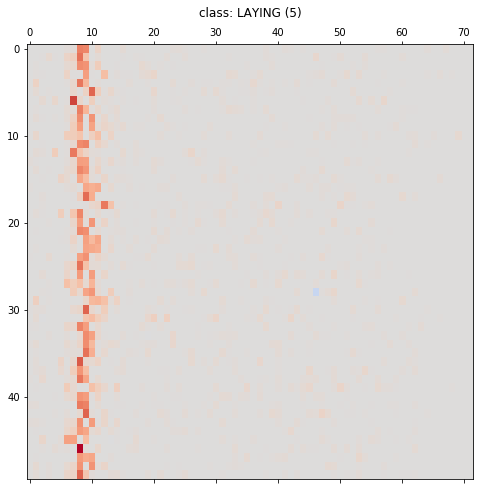

crule0


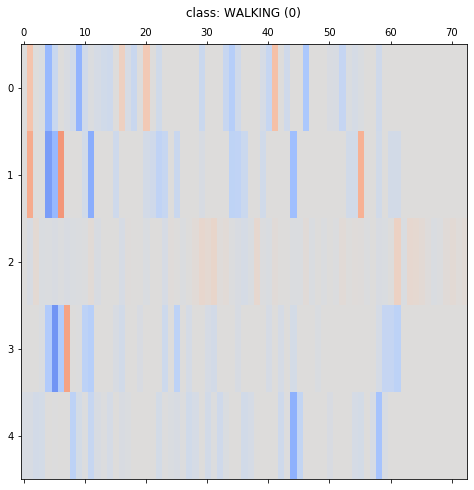

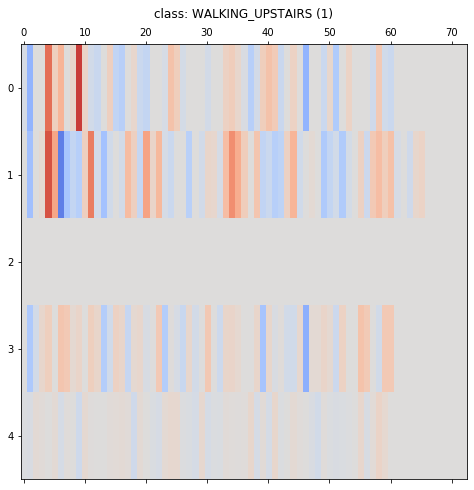

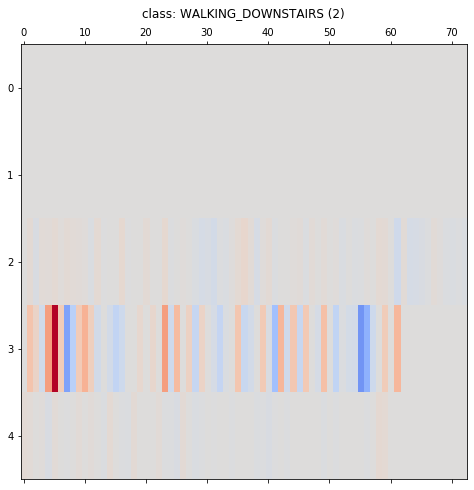

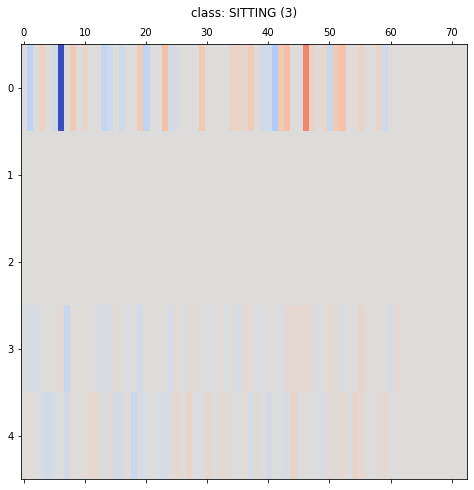

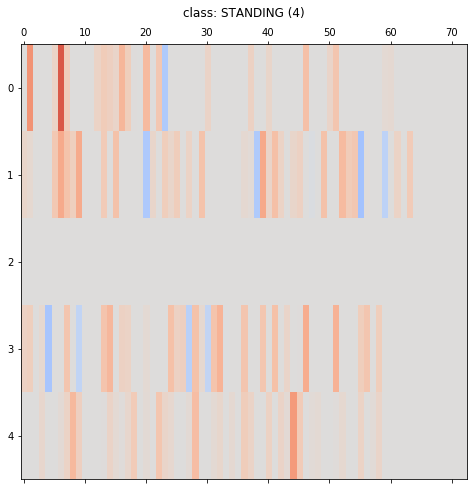

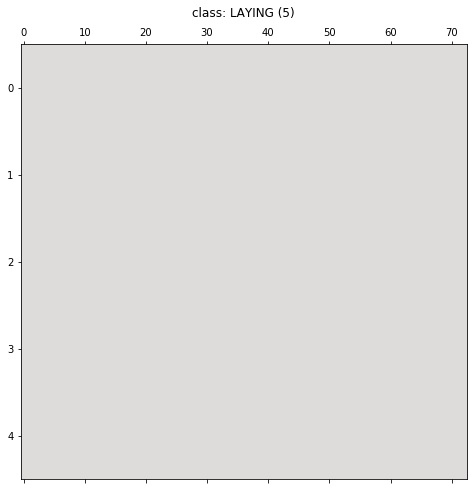

In [32]:
params = {"nsamples":1000, 
          "background":"linear", 
          "pen":1, 
          "peltmodel":"rbf",
          "jump": 1,
          "graph_out_file":None,
          "shapelet_mapper":None, 
          "VAE_2d_grid_size":9,
          "multishap_n":50,
          "max_iter":100}
agnostic.plot_explanation( 
                         rules = False, 
                         heatmap = False, 
                         shap_explanation = True, 
                         shapelet_explanation = False,
                         latent_space = False,
                         multi_shap_explanation = True,
                         figsize = (20,3),
                         VAE_2d = False,
                         **params
                         )